# Udacity Self-Driving Car Project: Advanced Lane Finding
___
#### The goals of this project are:
* To make the lane detection pipeline more robust to changes in lane color and changes in lighting conditions than when we first implemented the pipeline in the [CarND-LaneLines-P1](https://github.com/eeeja/CarND-LaneLines-P1) implementation.
* To calculate the curvature of the lanes so that we can adjust the steering wheel correctly.
___
#### We do this by using the following techniques:
1. [Correct Radial Distortion](#correct-radial-distortion): Compute and correct the camera calibration matrix and distortion coefficients given a set of chessboard images.
    * [Calibrate Camera](#calibrate-camera)
    * [Undistort Image](#undistort-image)
2. [Find Lane Lines](#find-lane-lines): Use color transforms & pixel gradients to detect lane line edges.
    * [ID Best Color Maps](#id-best-color-maps)
    * [Find Sobel Gradients](#find-sobel-gradients)
3. [Calculate Lane Line Curvature](#calculate-lane-line-curvature): Apply a perspective transform to rectify binary image ("birds-eye view").
    * [Calculate Birdseye Perspective](#calculate-birdseye-perspective)
    * [Detect lane pixels](#detect-lane-pixels)
    * [Determine Lane Curvature](#determine-lane-curvature)

This notebook explores in detail the python implementation of the lane detection pipeline. For a more analytical overview of the pipeline, please see [Writeup](https://github.com/eeeja/CarND-LaneLines-P1/blob/master/P1.ipynb) located at './Writeup.md'
___

### <a name="radial-distortion">Correct Radial Distortion</a>
Image Distortion happens when a 3D object is transformed to a 2D image. There are two forms of image distortion: Radial and perspective distortion. Here we focus on correcting the radial distortion. Further down at [Calculate Birdseye Perspective](#calculate-birdseye-perspective) we will adjust for the perspective distortion. 

Radial Distortion happens when curved lenses in cameras bend light rays too much at the edge of lenses-- edges of images appear more/less curved than they actually are.

$$x_{corrected} = x(1+k_1r^2+k_2r^4+k_3r^6)$$
$$y_{corrected} = y(1+k_1r^2+k_2r^4+k_3r^6)$$
___
#### <a name="calibrate-camera">Calibrate Camera</a>
To fix radial distortion, first we begin by calibrating our camera. We do this by analyzing the checker images in the "./camera_cal" folder to determine what the camera matrix and distortion coefficients are. We need these values to understand how the camera lens distorts images when transforming from 3D objects to 2D images.

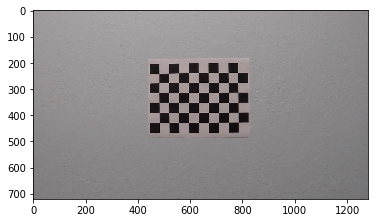

In [395]:
# Use cv2 functions findChessboardCorners() and drawChessboardCorners() 
# to find and draw corners of an imageimport numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Number of corners inside the checker image in X and Y dimensions
nx = 9# Manually counted corners within the image
ny = 6# Manually counted corners within the image

# Make a list of calibration images
# Edited image in Paint so it could have a white background
fname = './camera_cal/calibration6.jpg' 
img = cv2.imread(fname)
plt.imshow(img)

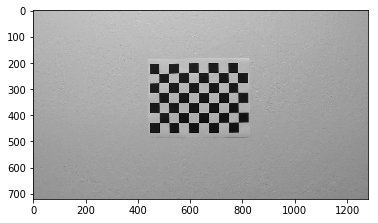

In [396]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

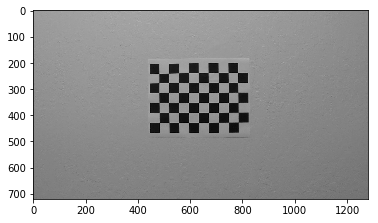

In [397]:
# Manipulate image to make white all white
threshold = 200
white_thresholds = gray[::]>=threshold
gray[white_thresholds] = 255
plt.imshow(gray,cmap='gray')

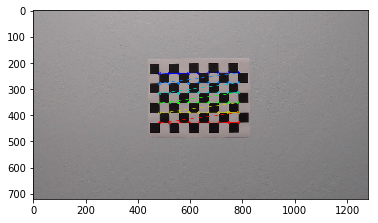

In [398]:
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

#### <a name="undistort-image">Undistort Image</a>
We need to run the above for all the checker images so that we can have a collection of image (distorted) points and object (undistorted) points. 
*Image points* refer to the $(x,y,z)$ coordinates of an object as displayed on the image. 
*Object points* refer to the $(x,y,z)$ coordinates of an object as displayed on the image. 
Below is a mini-pipeline which will process all images in the *camera_cal* folder to collect the image and object points. Code we ran above is aggregated below. The checker corner images and resulting corresponding undistorted are output to the *output_images* folder.

In [399]:
## Find all image and object points of Checker Images in camera_cal folder
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points
nx = 9# Manually counted corners within the image
ny = 6# Manually counted corners within the image
import os
import glob
images = glob.glob('./camera_cal/calibration*.jpg')

# Create output folder if it doesn't exist
output_folder = './output_images'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Camera Calibration variables to fix optical distortion from lens
objpoints = [] #3D points in real world space
imgpoints = [] #2D points on image

# Returns an array of object points
# Z dim will always be 0
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x, y coordinates

# Read in all images in camera_cal folder
# Collect imgpoints to use to undistort
for fname in images:
    img = cv2.imread(fname)

    # Step 1: Calibrate Camera 
    # We will use the camera calibrations detected from the checker images to determine the 
    # intrinsic camera properties which we will use downstream for our car camera images to 
    # undistort the video stream.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, draw corners
    if ret == True:
        # Append relevant points to use later on when undistorting images
        imgpoints.append(corners)
        objpoints.append(objp)
        checkered_img = img.copy()

        # Draw and display the corners
        cv2.drawChessboardCorners(checkered_img, (nx, ny), corners, ret)
        
        # Save id'd points to output folder
        save_fname = os.path.join(output_folder,'chessBoardCorners_' + os.path.basename(fname))
        cv2.imwrite(save_fname, checkered_img)

# Undistort Image
for fname in images:
    img = cv2.imread(fname)

    # Step 2: Correct for Distortion 
    undistorted = cal_undistort(img, objpoints, imgpoints)
    save_fname = os.path.join(output_folder,'undistorted_' + os.path.basename(fname))

    cv2.imwrite(save_fname, undistorted)

Here is an example of an original input image vs the undistorted output the above code generated. Notice how you can see some minor radial distortion on the right hand side where the edge of the board curves inside: ![Original Image](./camera_cal/calibration4.jpg)
The undistorted image looks like: ![Undistorted Image](./output_images/undistorted_calibration4.jpg)
Notice how the right hand side of the undistorted image is straighter than the original image.

### <a name="find-lane-lines">Find Lane Lines</a>
Now that we have adjusted for some of the optical distortions caused my the camera lens, we can begin manipulating the images to find the lane lines. 

Lane lines can be hard to detect in different lighting conditions and when they are different colors. Below we observe what color maps and gradients best bring out yellow and white lane lines in shadows and in the light.
___
#### <a name="id-best-color-maps">ID Best Color Maps</a>
**RGB color map:** As outlined in the sample images below, yellow lanes were harder to detect in the blue color space, as demonstrated below:

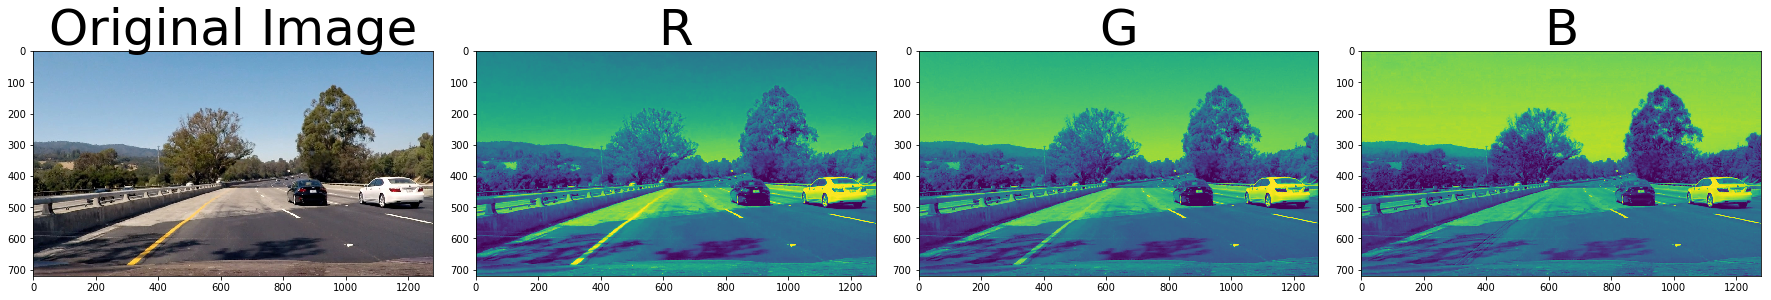

In [400]:
fname = './Elisa_Images/yellow_lane_shade.jpg' 
# cv2 reads in image as BGR
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img[:,:,(0)])
ax2.set_title('R', fontsize=50)
ax3.imshow(img[:,:,(1)])
ax3.set_title('G', fontsize=50)
ax4.imshow(img[:,:,(2)])
ax4.set_title('B', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**HSV color map:** HSV stands for hue, saturation, and value. Hue of a color refers to; saturation refers to, and value refers to the overal pixel intensity.

Here we see that the *hue* field does not extract the lane lines well. The *saturation* field seems to be able to single out yellow lines well, but not white lines. The *value* field seems to be best within the **HSV** color space to id white and yellow lines. 

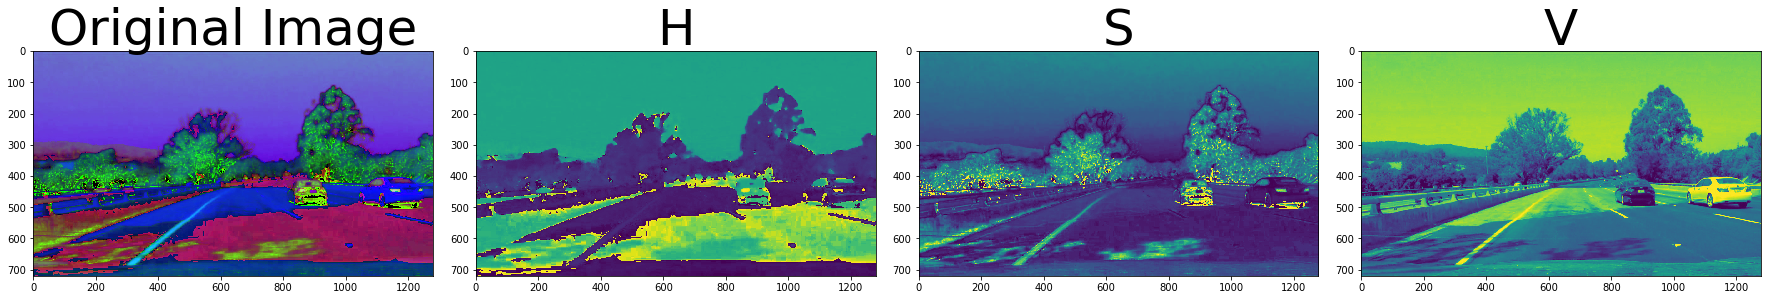

In [312]:
# Try playing with other color spaces: HSV
img = cv2.imread(fname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img[:,:,(0)])
ax2.set_title('H', fontsize=50)
ax3.imshow(img[:,:,(1)])
ax3.set_title('S', fontsize=50)
ax4.imshow(img[:,:,(2)])
ax4.set_title('V', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**HLS color map:** HLS stands for hue, lightness, and saturation. 

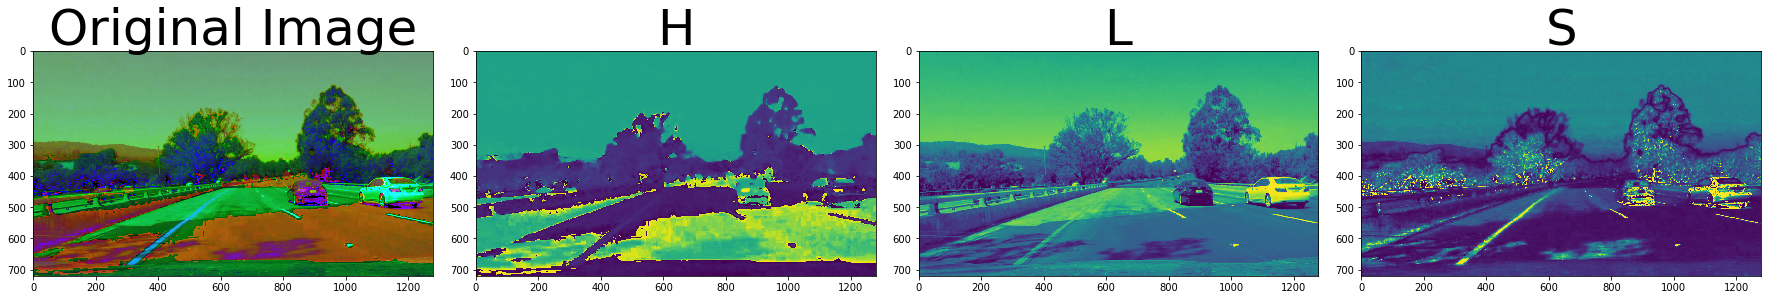

In [313]:
# Try playing with other color spaces: HLS
img = cv2.imread(fname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img[:,:,(0)])
ax2.set_title('H', fontsize=50)
ax3.imshow(img[:,:,(1)])
ax3.set_title('L', fontsize=50)
ax4.imshow(img[:,:,(2)])
ax4.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### <a name="find-sobel-gradients">Find Sobel Gradients</a>
The sobel operator is a [convolution](http://setosa.io/ev/image-kernels/) matrix which is used to approximate the changes in pixel intensity (gradient). This 
* [ID Best Color Maps](#best-color-maps)

$G_x = 
\left[ \begin{array}{cccc}
1 & 0 & -1 \\
2 & 0 & -2 \\
1 & 0 & -1 \\ \end{array} \right] * A$

$G_y = 
\left[ \begin{array}{cccc}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & 0 & -1 \\ \end{array} \right] * A$

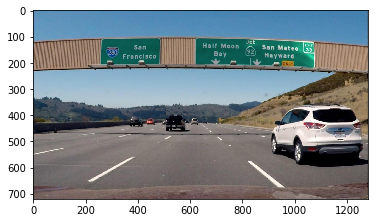

In [276]:
# Find best threshold parameters
fname = './Elisa_Images/signs_vehicles_xygrad.png' 
img = cv2.imread(fname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img)

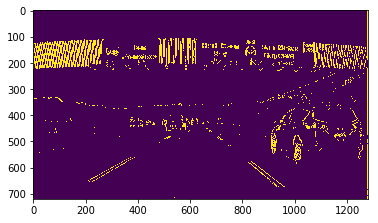

In [275]:
# Experiment using use various aspects of your gradient measurements 
# (x, y, magnitude, direction) to isolate lane-line pixels

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(30, 200))
plt.imshow(gradx)

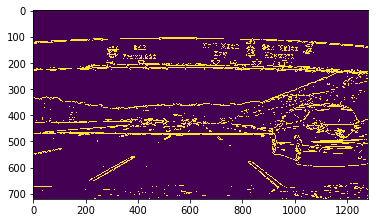

In [293]:
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
plt.imshow(grady)

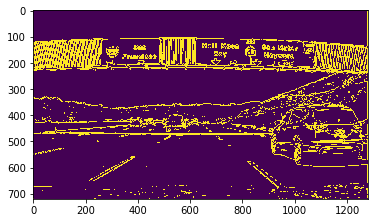

In [294]:
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
plt.imshow(mag_binary)

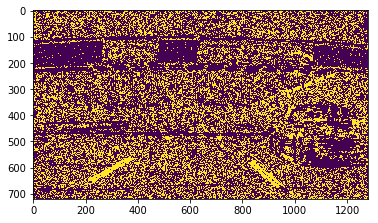

In [295]:
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
plt.imshow(dir_binary)

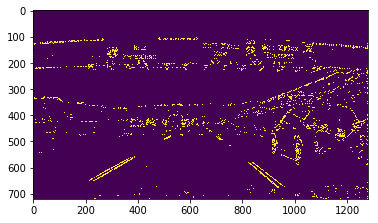

In [296]:
# Combine all gradients
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined)

## Threshold and Color
From the two sections above, we now know how to best combine color space and gradient thresholds to maximize our ability to detect lane lines in any lighting and of any color. 

In [354]:
## Helper Methods
## All these methods assume the image has been converted to a gray-scale image

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    # undist = np.copy(img)  # Delete this line
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped2 = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped2, M


# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 3) Calculate the magnitude 
    # abs_sobelx = np.sqrt(sobelx*sobelx)
    abs_sobelxy = np.sqrt(sobely*sobely+sobelx*sobelx)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    # binary_output = np.copy(img) # Remove this line
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(sobelx*sobelx)
    abs_sobely = np.sqrt(sobely*sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir =  np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
    
    
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    #s_thresh = [hls_img[:,:,(2)] >= thresh[1] & hls_img[:,:,(2)] < thresh[0]]
    
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(hls_img[:,:,(2)])
    binary_output[(hls_img[:,:,(2)] <= thresh[1]) & (hls_img[:,:,(2)] > thresh[0])] = 1
    return binary_output

* ** Tangential/Perspective Distortion: **
Objects in images look slanted because camera is not aligned perfectly parallel to the imaging plane.
(Source Udacity Self Driving Care Notes)
$$x_{corrected} = x+[2p_1xy+p_2(r^2+2x^2)]$$
$$y_{corrected} = y+[p_1(r^2+2y^2)+2p_2xy]$$

Characterize perspective by measuring z coordinate (distance from camera) = smaller in the image. Transform apparent z coordinate by zooming in on far away coordinates. Allowing us to view scenery from a different angle.

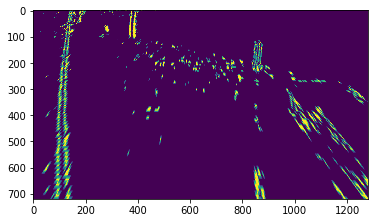

In [372]:
# Skipeed Section 30-- review code when less tired
# Confirm COde covers the following sections:
# Camera Calibration
# Distortion Correction
# Color & Gradient Threshold
# Perspective Transform

# Test undistort a lane line to retrieve bird's eye view
fname = './Elisa_Images/yellow_lane_shade.jpg' 
# cv2 reads in image as BGR
img = cv2.imread(fname)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
undistort = cal_undistort(img, objpoints,imgpoints)
gray = cv2.cvtColor(undistort, cv2.COLOR_BGR2GRAY)

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements
# Convert Birdseye view to binary with color & gradient threshold
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(30, 200))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(30, 100))


mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
plt.imshow(mag_binary)

dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

offset = 100 # offset for dst points
# Grab the image shape
img_size = (gray.shape[1], gray.shape[0])

# For source points I'm grabbing the outer four detected corners
src = np.float32([[427,584],[967,584],[600,463],[740,463]])
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32([[375,26], [891,26], 
                             [375,685], 
                             [891,685]])
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# Warp the image using OpenCV warpPerspective()
binary_warped = cv2.warpPerspective(combined, M, img_size)
plt.imshow(binary_warped)


## Finding Lanes
We now use a histogram to find the peaks of where white pixels are to determine where lane lines are.


In [389]:
index = int(binary_warped.shape[0]/2)
np.sum(binary_warped[index:,:],axis = 0)

array([  0.        ,   0.        ,   0.        , ...,  34.79199219,
        33.87207031,  32.78613281])

In [390]:
import numpy as np
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

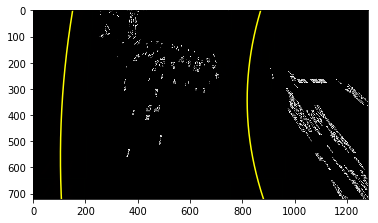

In [391]:
# VIsualize Result
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [392]:
# Set Sliding window 
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

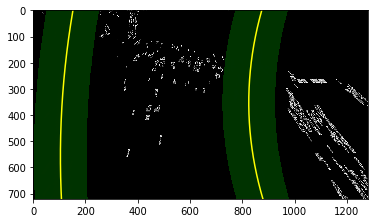

In [393]:
# Visualize Result
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [146]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None